In [1]:
import json
import pandas as pd
import os

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_data = []

# Read the file line by line
print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")
except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")



# Drop the batte 4877 which is wrong
train_data = [battle for battle in train_data if battle.get("battle_id") != 4877]

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.


In [2]:
BASE_KEYS = ['base_hp', 'base_atk', 'base_def', 'base_spa', 'base_spd', 'base_spe']

def build_species_index(*datasets):
    """
    Dizionario: specie → base stats Gen1.
    Usa p1_team_details (sempre completi) e p2_lead_details (se presenti).
    """
    idx = {}

    def take(p):
        name = str(p.get('name', '')).lower()
        if not name: return
        rec = {k: int(p.get(k, 0)) for k in BASE_KEYS}
        if name not in idx or sum(idx[name].values()) < sum(rec.values()):
            idx[name] = rec

    for data in datasets:
        for b in data:
            for p in b.get('p1_team_details', []):
                take(p)
            if b.get('p2_lead_details'):
                take(b['p2_lead_details'])
            for ev in b.get('battle_timeline', []):
                take(ev.get('p2_pokemon_state', {}))
    return idx

species_idx = build_species_index(train_data)

def get_lead_speed(battle: dict, player: str, species_idx: dict) -> int:
    """
    Restituisce la base_spe del lead di 'player' ('p1' o 'p2').
    Usa, in ordine di priorità:
      - p1_lead_details / p2_lead_details, se presenti
      - il primo p1_pokemon_state / p2_pokemon_state nella timeline
      - il primo Pokémon in p1_team_details (solo per p1) come fallback
    Se non trova nulla, ritorna 0.
    """
    name = None

    # 1) Prova con i campi *_lead_details
    if player == 'p1':
        name = battle.get('p1_lead_details', {}).get('name')
    elif player == 'p2':
        name = battle.get('p2_lead_details', {}).get('name')

    # 2) Se il lead non è definito esplicitamente, prova a leggere il primo turno della timeline
    if not name:
        timeline = battle.get('battle_timeline', [])
        if timeline:
            if player == 'p1':
                name = timeline[0].get('p1_pokemon_state', {}).get('name')
            elif player == 'p2':
                name = timeline[0].get('p2_pokemon_state', {}).get('name')

    # 3) Fallback per p1: primo della squadra
    if not name and player == 'p1':
        p1_team = battle.get('p1_team_details', [])
        if p1_team:
            name = p1_team[0].get('name')

    if not name:
        return 0

    stats = species_idx.get(str(name).lower())
    if not stats:
        return 0

    return int(stats.get('base_spe', 0))

def track_pokemon_conditions(battle):
    """
    Iterates through the timeline of a battle to track the conditions of each Pokémon
    """
    # Initialize the data structure
    p1_pok_cond = {pokemon.get('name', f'p1_unknown_{i}'):
    {
      'hp': 1.00,
      'status': 'nostatus'
    } for i, pokemon in enumerate(battle.get('p1_team_details', []))}
    p2_pok_cond = {}
    p2_pok_cond[battle.get('p2_lead_details', {}).get('name')] = {
      'hp': 1.00,
      'status': 'nostatus'
    }

    # Fill the values with the latest conditions shown in the timeline
    for turn in battle.get('battle_timeline', []):
      p1_pok_cond[turn.get('p1_pokemon_state', {}).get('name')] = {
          'hp': turn.get('p1_pokemon_state', {}).get('hp_pct'),
          'status': turn.get('p1_pokemon_state', {}).get('status')
      }
      p2_pok_cond[turn.get('p2_pokemon_state', {}).get('name')] = {
          'hp': turn.get('p2_pokemon_state', {}).get('hp_pct'),
          'status': turn.get('p2_pokemon_state', {}).get('status')
      }

    # Compute the number of pokemon changes for each player (indicator of strategy)
    p1_n_changes = 0
    p2_n_changes = 0
    for turn in battle.get('battle_timeline', []):
      p1_current_pok = turn.get('p1_pokemon_state', {}).get('name')
      p2_current_pok = turn.get('p2_pokemon_state', {}).get('name')
      if turn != battle.get('battle_timeline', [])[0]:
        if p1_pre_pok != p1_current_pok:
          p1_n_changes += 1
        if p2_pre_pok != p2_current_pok:
          p2_n_changes += 1
      else:
        p1_pre_pok = p1_current_pok
        p2_pre_pok = p2_current_pok

    # Compute the number of effects working on the last round and weigh them
    p1_effects = len(battle.get('battle_timeline', [])[-1].get('p1_pokemon_state', {}).get('effects', []))*0.2
    p2_effects = len(battle.get('battle_timeline', [])[-1].get('p2_pokemon_state', {}).get('effects', []))*0.2

    # Add the slots corresponding to the unseen pokemons of player #2
    for i in range(len(p2_pok_cond), 6):
      p2_pok_cond[f'p2_unknown_{i}'] = {
          'hp': 1.00,
          'status': 'nostatus'
      }
    return p1_n_changes, p1_effects, p1_pok_cond, p2_n_changes, p2_effects, p2_pok_cond

def compute_differences_base_stats(p1_pok_cond, p2_pok_cond, species_idx):
  """
  Calculates the difference in total base stats between player #1 and player #2
  """
  p1_total_speed = 0
  p2_total_speed = 0
  p1_total_attack = 0
  p2_total_attack = 0
  p1_total_defense = 0
  p2_total_defense = 0
  p1_total_sp_attack = 0
  p2_total_sp_attack = 0
  p1_total_sp_defense = 0
  p2_total_sp_defense = 0
  p1_total_hp = 0
  p2_total_hp = 0
  for pokemon in p1_pok_cond.keys():
    if pokemon in species_idx:
      p1_total_speed += species_idx[pokemon]['base_spe']
      p1_total_attack += species_idx[pokemon]['base_atk']
      p1_total_defense += species_idx[pokemon]['base_def']
      p1_total_sp_attack += species_idx[pokemon]['base_spa']
      p1_total_sp_defense += species_idx[pokemon]['base_spd']
      p1_total_hp += species_idx[pokemon]['base_hp']
  for pokemon in p2_pok_cond.keys():
    if pokemon in species_idx:
      p2_total_speed += species_idx[pokemon]['base_spe']
      p2_total_attack += species_idx[pokemon]['base_atk']
      p2_total_defense += species_idx[pokemon]['base_def']
      p2_total_sp_attack += species_idx[pokemon]['base_spa']
      p2_total_sp_defense += species_idx[pokemon]['base_spd']
      p2_total_hp += species_idx[pokemon]['base_hp']
  speed = p1_total_speed-p2_total_speed
  defense = p1_total_defense-p2_total_defense
  attack = p1_total_attack-p2_total_attack
  sp_attack = p1_total_sp_attack-p2_total_sp_attack
  sp_defense = p1_total_sp_defense-p2_total_sp_defense
  hp = p1_total_hp-p2_total_hp
  return speed, defense, attack, sp_attack, sp_defense, hp

# TO BE REMOVED
def get_all_statuses(data: list[dict]):
    all_statuses = set()

    for battle in tqdm(data, desc="Scanning for statuses"):
        for turn in battle.get('battle_timeline', []):
            p1_state = turn.get('p1_move_details')
            if p1_state and 'name' in p1_state:
                all_statuses.add(p1_state['name'])
            p2_state = turn.get('p2_move_details')
            if p2_state and 'name' in p2_state:
                all_statuses.add(p2_state['name'])
    print(all_statuses)
    return all_statuses

In [3]:
from tqdm.notebook import tqdm
import numpy as np

from tqdm.notebook import tqdm
import numpy as np

def create_features(data: list[dict]) -> pd.DataFrame:
    """
    Estrae feature basate sulla battle timeline e sulle base stats.

    Features attuali:
    - p1_mean_pc_hp, p2_mean_pc_hp
    - p1_surviving_pokemon, p2_surviving_pokemon
    - p1_status_score, p2_status_score
    - total_*_difference (speed, atk, def, sp_atk, sp_def, hp)
    - NUOVE:
      - lead_speed_diff = base_spe(lead_p1) - base_spe(lead_p2)
      - switch_diff = p1_n_changes - p2_n_changes
    """
    feature_list = []

    for battle in tqdm(data, desc="Extracting features"):
        features = {}
        timeline = battle.get('battle_timeline', [])

        # Track conditions, switches, effects
        p1_n_changes, p1_effects, p1_pok_cond, p2_n_changes, p2_effects, p2_pok_cond = track_pokemon_conditions(battle)

        # =========================
        # 1) HP medi e surviving
        # =========================
        p1_mean_pc_hp = np.mean([info['hp'] for info in p1_pok_cond.values()])
        p2_mean_pc_hp = np.mean([info['hp'] for info in p2_pok_cond.values()])
        features['p1_mean_pc_hp'] = p1_mean_pc_hp
        features['p2_mean_pc_hp'] = p2_mean_pc_hp

        p1_surviving_pokemon = sum(1 for info in p1_pok_cond.values() if info["hp"] > 0)
        p2_surviving_pokemon = sum(1 for info in p2_pok_cond.values() if info["hp"] > 0)
        features['p1_surviving_pokemon'] = p1_surviving_pokemon
        #features['p2_surviving_pokemon'] = p2_surviving_pokemon

        # =========================
        # 2) Status score
        # =========================
        p1_status_score = sum(
            1 for i in p1_pok_cond.values()
            if i['hp'] > 0 and i['status'] != 'nostatus'
        ) + p1_effects
        p2_status_score = sum(
            1 for i in p2_pok_cond.values()
            if i['hp'] > 0 and i['status'] != 'nostatus'
        ) + p2_effects
        features['p1_status_score'] = p1_status_score
        features['p2_status_score'] = p2_status_score

        # =========================
        # 3) Differenze base stats totali
        # =========================
        speed, defense, attack, sp_attack, sp_defense, hp = compute_differences_base_stats(
            p1_pok_cond, p2_pok_cond, species_idx
        )
        features['total_speed_difference'] = speed
        features['total_attack_difference'] = attack
        features['total_defense_difference'] = defense
        features['total_sp_attack_difference'] = sp_attack
        #features['total_sp_defense_difference'] = sp_defense
        features['total_hp_difference'] = hp

        # =========================
        # 4) NUOVA FEATURE: SWITCH DIFF
        # =========================
        # se vuoi puoi salvare anche i valori singoli
        # features['p1_n_changes'] = p1_n_changes
        # features['p2_n_changes'] = p2_n_changes
        features['switch_diff'] = p1_n_changes - p2_n_changes

        # =========================
        # 5) NUOVA FEATURE: LEAD SPEED DIFF
        # =========================
        p1_lead_speed = get_lead_speed(battle, 'p1', species_idx)
        p2_lead_speed = get_lead_speed(battle, 'p2', species_idx)
        features['lead_speed_diff'] = p1_lead_speed - p2_lead_speed

        # =========================
        # 6) Meta info: id & target
        # =========================
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])

        feature_list.append(features)

    return pd.DataFrame(feature_list).fillna(0)
# Create feature DataFrames for both training and test sets
print("Processing training data...")
train_df = create_features(train_data)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_features(test_data)

print("\nTraining features preview:")
display(train_df.head())

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
y_train = train_df['player_won']

X_test = test_df[features]

Processing training data...


Extracting features:   0%|          | 0/9999 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


Training features preview:


,p1_mean_pc_hp,p2_mean_pc_hp,p1_surviving_pokemon,p1_status_score,p2_status_score,total_speed_difference,total_attack_difference,total_defense_difference,total_sp_attack_difference,total_hp_difference,switch_diff,lead_speed_diff,battle_id,player_won
0,0.645469,0.441250,5,2.2,3.2,230,150,140,205,130,3,0,0,1
1,0.263333,0.428333,3,0.2,3.2,-110,0,15,-60,45,-3,-25,1,1
2,0.696667,0.693333,5,1.2,3.2,5,285,225,100,305,-11,5,2,1
3,0.340000,0.476667,3,0.2,1.2,145,60,85,260,325,3,0,3,1
4,0.626667,0.525000,5,2.2,4.2,75,70,140,120,45,-1,5,4,1


In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
# =========================
# CV comune
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =========================
# 1) MODELLI BASE + GRIGLIE IPERPARAMETRI
#    (griglie "leggere", come richiesto)
# =========================

# --- Logistic Regression (con scaler) ---
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=1000,
        solver='liblinear',  # supporta l1 e l2
        random_state=42
    ))
])

param_lr = {
    'logreg__C': [0.1, 1.0, 10.0],
    'logreg__penalty': ['l1', 'l2']
}

# --- KNN (con scaler) ---
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_knn = {
    'knn__n_neighbors': [5, 11, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]   # Manhattan / Euclidea
}

# --- SVM (con scaler) ---
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

param_svm = {
    'svm__C': [0.5, 1.0, 5.0],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

# --- Random Forest ---
rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

param_rf = {
    'n_estimators': [200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# --- XGBoost ---
xgb = XGBClassifier(
    tree_method='hist',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

param_xgb = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# =========================
# 2) GRID SEARCH PER OGNI MODELLO BASE
#    (uso roc_auc come metrica, puoi cambiare in 'accuracy' se vuoi)
# =========================

def tune_model(estimator, param_grid, X, y, cv, scoring='accuracy', name='model'):
    print(f"\nTuning {name}...")
    gs = GridSearchCV(
        estimator,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X, y)
    print(f"Best params for {name}: {gs.best_params_}")
    print(f"Best {scoring} for {name}: {gs.best_score_:.4f}")
    return gs.best_estimator_

best_lr  = tune_model(lr_pipe,  param_lr,  X_train, y_train, cv, name='Logistic Regression')
best_knn = tune_model(knn_pipe, param_knn, X_train, y_train, cv, name='KNN')
best_svm = tune_model(svm_pipe, param_svm, X_train, y_train, cv, name='SVM')
best_rf  = tune_model(rf,       param_rf,  X_train, y_train, cv, name='Random Forest')
best_xgb = tune_model(xgb,      param_xgb, X_train, y_train, cv, name='XGBoost')

# =========================
# 3) STACKING CLASSIFIER
# =========================

base_estimators = [
    ('lr',  best_lr),
    ('knn', best_knn),
    ('svm', best_svm),
    ('rf',  best_rf),
    ('xgb', best_xgb)
]

# Meta-modello: logistic regression (molto più sensata per classificazione binaria)
final_estimator = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=42
)

stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=cv,
    n_jobs=-1,
    passthrough=False  # se vuoi aggiungere anche le feature originali al meta, metti True
)

print("\nFitting stacking classifier...")
stack_clf.fit(X_train, y_train)

# =========================
# 4) PREVISIONI SU TEST
# =========================

# Probabilità di vittoria (classe 1)
y_test_proba = stack_clf.predict_proba(X_test)[:, 1]

# Se ti serve anche la classe predetta:
y_test_pred = stack_clf.predict(X_test)

print("\nEsempio prime probabilità:", y_test_proba[:10])

print("\nValutazione meta-modello (Stacking) con CV=5...")

stack_scores = cross_val_score(
    stack_clf,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f"Accuracy media Stacking (CV=5): {stack_scores.mean():.4f}")
print(f"Deviazione standard:             {stack_scores.std():.4f}")


Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for Logistic Regression: {'logreg__C': 1.0, 'logreg__penalty': 'l2'}
Best accuracy for Logistic Regression: 0.8484

Tuning KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for KNN: {'knn__n_neighbors': 21, 'knn__p': 1, 'knn__weights': 'uniform'}
Best accuracy for KNN: 0.8386

Tuning SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for SVM: {'svm__C': 0.5, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best accuracy for SVM: 0.8472

Tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best accuracy for Random Forest: 0.8416

Tuning XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Esempio prime probabilità: [0.10144655 0.94034376 0.94804726 0.95273801 0.86799802 0.32010702
 0.93657325 0.81299416 0.94370607 0.94765575]

Valutazione meta-modello (Stacking) con CV=5...
Accuracy media Stacking (CV=5): 0.8496
Deviazione standard:             0.0044


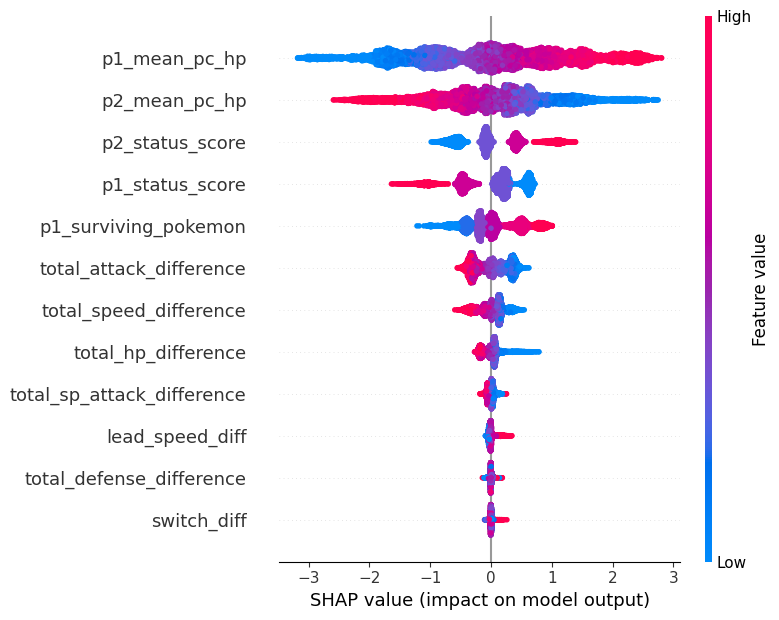

In [5]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)


In [6]:
# --- Submission ---
submission = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Salvata: submission.csv")

Salvata: submission.csv
